In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Call Libraries
import scipy
import numpy as np
import matplotlib as plt
import pandas as pd
import sklearn

In [3]:
import os

# Define the base path to data
base_path = '/content/drive/MyDrive/SoundCloud'

# Read each file into its own DataFrame
affiliations = pd.read_stata(os.path.join(base_path, '12affiliations_sample.dta'))
comments = pd.read_stata(os.path.join(base_path, '12comments_sample.dta'))
favoritings = pd.read_stata(os.path.join(base_path, '12favoritings_sample.dta'))
messages = pd.read_stata(os.path.join(base_path, '12messages_sample.dta'))
reposts = pd.read_stata(os.path.join(base_path, '12reposts_sample.dta'))

In [4]:
users = pd.read_csv(os.path.join(base_path, 'user_ids.csv'))
users.head(20)

,Unnamed: 0,user_id,type,created_at
0,1,54849,creator,2009-01-01 00:47:08
1,2,54869,creator,2009-01-01 05:24:26
2,3,54882,creator,2009-01-01 09:28:54
3,4,54901,creator,2009-01-01 13:10:30
4,5,54912,creator,2009-01-01 14:20:57
5,6,54928,NaN,2009-01-01 15:27:56
6,7,54955,NaN,2009-01-01 17:25:34
7,8,54958,creator,2009-01-01 17:34:22
8,9,54969,NaN,2009-01-01 18:15:14
9,10,54994,creator,2009-01-01 19:22:19


In [5]:
creators_df = users[users['type'] == 'creator'].copy()
display(creators_df.head())
# Extract the creator IDs as a list or Series for use in functions
creators = creators_df['user_id'].unique()

,Unnamed: 0,user_id,type,created_at
0,1,54849,creator,2009-01-01 00:47:08
1,2,54869,creator,2009-01-01 05:24:26
2,3,54882,creator,2009-01-01 09:28:54
3,4,54901,creator,2009-01-01 13:10:30
4,5,54912,creator,2009-01-01 14:20:57


In [6]:
# Peek at Data
display(affiliations.head())
display(comments.head())
display(favoritings.head())
display(messages.head())
display(reposts.head())
display(creators_df.head())

,fan_id,contact_id,created_at
0,55250,45724,2009-01-02 15:14:42
1,55250,2629,2009-01-02 15:15:47
2,55250,4230,2009-01-02 15:15:56
3,55250,3082,2009-01-02 15:16:05
4,55250,3107,2009-01-02 15:16:13


,user_id,track_id,owner_id,created_at
0,56125,4912,274,2009-01-06 11:57:50
1,54181,116480,61390,2009-01-27 02:45:05
2,3983,125334,64864,2009-02-08 18:04:24
3,65739,140931,65739,2009-02-11 21:36:27
4,65739,140931,65739,2009-02-11 21:40:18


,user_id,track_id,owner_id,created_at
0,55806,98214,54084,2009-01-03 23:47:10
1,56588,100073,2153,2009-01-07 18:14:02
2,57524,103677,57276,2009-01-08 00:18:19
3,58048,58062,29763,2009-01-11 18:06:08
4,60584,55187,31543,2009-01-16 18:16:40


,sender_id,receiver_id,created_at
0,51272,55102,2009-01-02 22:43:33
1,54878,7915,2009-01-02 20:16:08
2,54878,7915,2009-01-04 21:58:29
3,54878,7915,2009-01-04 22:08:09
4,55013,52969,2009-01-03 03:35:42


,reposter_id,created_at,song_id,owner_id
0,194980,2012-06-07 11:52:27,48909076,80522
1,503949,2012-06-16 07:05:33,48718310,70917
2,194980,2012-06-17 16:01:50,49252926,80522
3,7564356,2012-07-02 21:44:03,7510652,84543
4,1762257,2012-07-04 16:22:40,43089879,61522


,Unnamed: 0,user_id,type,created_at
0,1,54849,creator,2009-01-01 00:47:08
1,2,54869,creator,2009-01-01 05:24:26
2,3,54882,creator,2009-01-01 09:28:54
3,4,54901,creator,2009-01-01 13:10:30
4,5,54912,creator,2009-01-01 14:20:57


#### **Define Parameters**
- Threshold = Cut-off for number of followers
- Window-Days = Days since influencer crosses threshold
- Top_K = Number of creators 'k' to be viewed

In [7]:
THRESHOLD = 50
WINDOW_DAYS = 180

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Sorting Affiliations by timestamps**
- Clean the affiliations (follow) dataset.
- Keep only fan_id, contact_id, and created_at.
- Convert timestamps to datetime.
- Coerces IDs to numeric, remove missing values, sort by time, and drop duplicate follow edges.

**Output:** Time-ordered follower-following relationships.

In [9]:
def prep_affiliations(affiliations):
    a = affiliations[["fan_id", "contact_id", "created_at"]].copy()
    a["created_at"] = pd.to_datetime(a["created_at"], errors="coerce")
    a = a.dropna(subset=["fan_id", "contact_id", "created_at"])
    a["fan_id"] = pd.to_numeric(a["fan_id"], errors="coerce")
    a["contact_id"] = pd.to_numeric(a["contact_id"], errors="coerce")
    a = a.dropna(subset=["fan_id", "contact_id"])
    a = a.sort_values("created_at")
    a = a.drop_duplicates(subset=["fan_id", "contact_id"], keep="first")
    return a

display(prep_affiliations(affiliations))

,fan_id,contact_id,created_at
38480,54848,14730,2009-01-01 01:01:04
39220,54846,4610,2009-01-01 02:12:39
39221,54846,6281,2009-01-01 02:13:21
39222,54846,15386,2009-01-01 02:17:50
39223,54846,1214,2009-01-01 02:25:23
...,...,...,...
30493729,81303,83118585,2014-03-19 02:24:29
30673499,85286217,87783,2014-03-19 02:24:30
30673500,85286217,60663,2014-03-19 02:24:31
29822351,9348702,75620,2014-03-19 02:24:35


#### **Time-ordered list of creators**
- Computes when each creator reaches a follower threshold.
- Filters follow events to creators.
- Sorts follower arrivals chronologically.
- Assigns cumulative follower ranks per creator.
- Selects the timestamp when the rank equals the predefined threshold.

**Ouput:** Series mapping each creator to their threshold-crossing time.

In [10]:
def compute_tcross(a, creators):
    fe = a[a["contact_id"].isin(creators)].copy()
    fe = fe.sort_values(["contact_id", "created_at"])
    # Groups the DataFrame fe by each unique contact_id = applied independently to each creator)
    # Since cumcount() starts from 0, adding 1 makes the rank start from 1
    fe["rank"] = fe.groupby("contact_id").cumcount() + 1

    tcross = (
        fe[fe["rank"] == THRESHOLD]
        .set_index("contact_id")["created_at"]
    )
    # Explicitly assign the name "tcross" to the pd series
    tcross.name = "tcross"
    return tcross

display(compute_tcross(affiliations, creators))

,tcross
contact_id,
54846,2012-02-17 00:18:34
54847,2010-06-28 09:37:11
54861,2010-02-08 21:37:49
54866,2010-08-11 20:21:17
54869,2013-02-26 23:34:51
...,...
93702,2011-03-16 19:13:17
93703,2009-10-19 16:52:16
93705,2009-10-14 06:52:55


#### **Compute Reciprocal Ties**
- Identifies reciprocal (mutual) follow ties among creators.
- Extract directed follow edges
- Filter them to creator–creator relationships
- Perform a *self-merge* with reversed edges to retain only pairs where both users follow each other.

**Output:** Produce a clean set of reciprocal strong-tie candidates.

In [11]:
def reciprocal_ties(a, creators):
    # Extracts directed follow edges from the affiliations dataset
    edges = a[["fan_id", "contact_id"]].copy()
    # Renames as a directed edge u → v
    edges = edges.rename(columns={"fan_id": "u", "contact_id": "v"})
    # Filter analysis to keep creator–creator relationships
    edges = edges[
        edges["u"].isin(creators) &
        edges["v"].isin(creators)
    ]

    # Strong ties: Match each edge with its reversed counterpart (v → u)
    recip = edges.merge(
        edges.rename(columns={"u": "v", "v": "u"}),
        on=["u", "v"],
        how="inner"
    )
    # Reciprocal ties are bidirected since both u and v follow each other
    return recip.drop_duplicates()

display(reciprocal_ties(affiliations, creators))

,u,v
0,56775,57376
1,57572,58696
2,59096,59531
3,59763,58817
4,60338,56788
...,...,...
44039,77934,69675
44040,69905,75684
44041,70183,84083
44042,60882,80245


**Checking for distinct creators in each column**

In [12]:
recip_df = reciprocal_ties(affiliations, creators)

distinct_u_count = recip_df['u'].nunique()
distinct_v_count = recip_df['v'].nunique()

print(f"Distinct count in 'u' column: {distinct_u_count}")
print(f"Distinct count in 'v' column: {distinct_v_count}")

Distinct count in 'u' column: 8828
Distinct count in 'v' column: 8828


This visualization shows the network of reciprocal ties. Each dot (node) represents a creator, and each line (edge) represents a mutual following relationship. Denser areas indicate creators who are part of more interconnected groups of strong ties. Due to the large number of creators, individual labels are suppressed to keep the visualization clear.

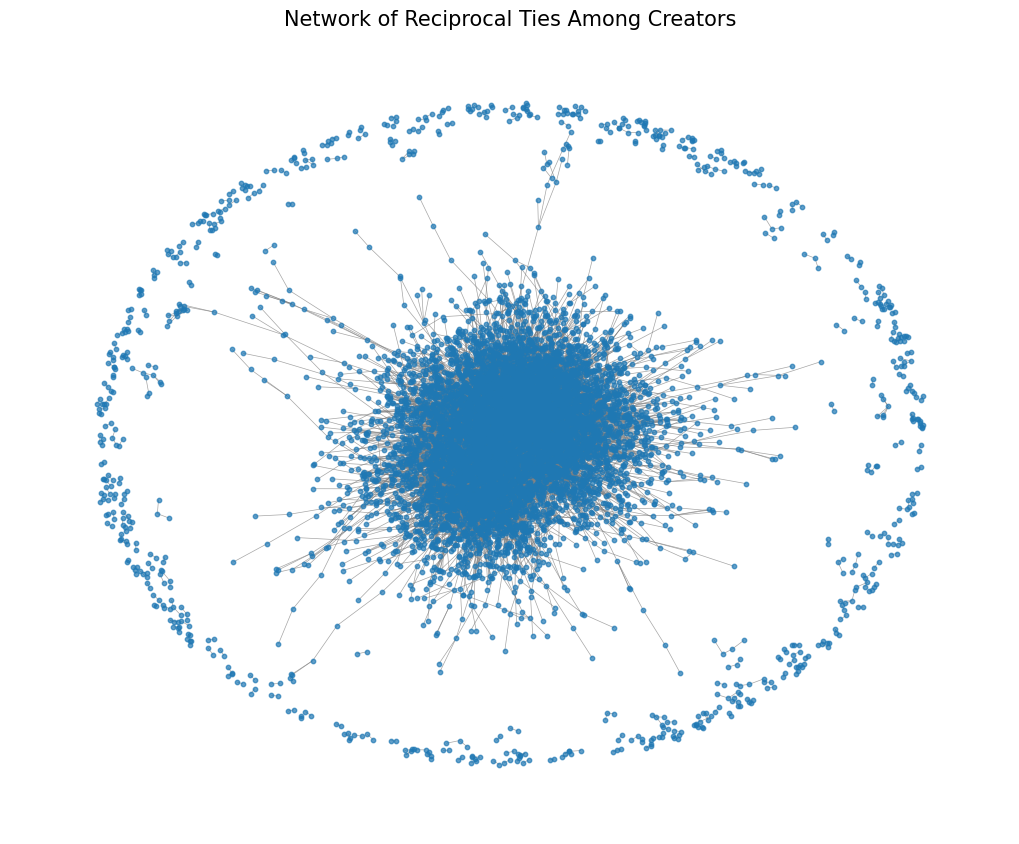

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from the reciprocal ties DataFrame
G = nx.from_pandas_edgelist(recip_df, 'u', 'v', create_using=nx.Graph)

# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.1) # Use spring layout for better visualization of clusters
nx.draw(G, pos, with_labels=False, node_size=10, width=0.5, alpha=0.7, edge_color='gray')
plt.title('Network of Reciprocal Ties Among Creators', size=15)
plt.show()

####**Sort, clean, merge, and classify each interaction type by source and target**
- Convert timestamps, remove missing or invalid IDs.
- Excludes self-interactions.
- Rename columns to a consistent source–target format.
- Concatenate both datasets.

**Output:** Single time-ordered interaction table for tie-intensity analysis.

In [14]:
def build_interactions(comments, favoritings, messages, reposts):
    def clean(df, interaction_type):
        df = df[["user_id", "owner_id", "created_at"]].copy()
        df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
        df = df.dropna(subset=["user_id", "owner_id", "created_at"])
        # Coercing values in the df in "user_id" and "owner_id" to be numeric
        df["user_id"] = pd.to_numeric(df["user_id"], errors="coerce")
        df["owner_id"] = pd.to_numeric(df["owner_id"], errors="coerce")
        df = df.dropna(subset=["user_id", "owner_id"])
        # Remove self-interactions
        df = df[df["user_id"] != df["owner_id"]]
        df = df.rename(columns={
            "user_id": "source",
            "owner_id": "target",
            "created_at": "time"
        })
        df['interaction_type'] = interaction_type # Add a column for interaction type
        return df

    interactions = pd.concat([
        clean(comments, 'comment'),
        clean(favoritings, 'favoriting'),
        clean(messages.rename(columns={"sender_id": "user_id", "receiver_id": "owner_id"}), 'message'),
        clean(reposts.rename(columns={"reposter_id": "user_id"}), 'repost')
    ], ignore_index=True)
    return interactions.sort_values(["source", "time"])

display(build_interactions(comments, favoritings, messages, reposts))

,source,target,time,interaction_type
14699112,2,56061,2009-01-08 19:37:05,message
13522359,2,92292,2009-04-02 15:08:39,message
14579610,2,77676,2009-05-17 01:18:06,message
3042122,2,76216,2011-02-19 14:35:09,favoriting
3042130,2,76216,2011-02-19 18:23:13,favoriting
...,...,...,...,...
17056476,94461189,60663,2014-05-13 22:41:05,repost
17056477,94461189,60663,2014-05-13 22:43:40,repost
16926425,94463435,81166,2014-05-13 22:56:42,repost
16987437,94466307,67248,2014-05-13 23:19:51,repost


**Why we merge only "u" on "contact_id" and not "v" as well?**
- **Symmetry:** If u is in a reciprocal tie with v (meaning (u, v) is in recip_df), then v is also in a reciprocal tie with u (meaning (v, u) is also implicitly, or explicitly as another row, part of the reciprocal set.
- Because of this symmetry, any creator that appears in the 'u' column (as someone initiating a mutual follow) must also appear in the 'v' column (as someone being mutually followed by another creator).
- Conversely, any creator in the 'v' column must also be in the 'u' column. Therefore, the set of unique creators in the 'u' column is precisely the same as the set of unique creators in the 'v' column, leading to identical distinct counts.

In [15]:
def intensity_pre_post(interactions, recip, tcross):

    # Keep only creators who crossed threshold
    crossed = tcross.index
    recip = recip[recip["u"].isin(crossed)].copy()

    # Attach tcross to edges
    recip = recip.merge(
        tcross.reset_index(),
        left_on="u",
        right_on="contact_id",
        how="inner"
    ).rename(columns={"contact_id": "creator_id"})

    # The tcross column should already be datetime from compute_tcross and prep_affiliations.
    # Remove dayfirst=True as it's causing incorrect parsing for YYYY-MM-DD format.
    recip["tcross"] = pd.to_datetime(recip["tcross"])
    recip["post_end"] = recip["tcross"] + pd.Timedelta(days=WINDOW_DAYS)

    # Match interactions along reciprocal edges
    ev = interactions.merge(
        recip[["u", "v", "tcross", "post_end"]],
        left_on=["source", "target"],
        right_on=["u", "v"],
        how="inner"
    )

    # Ensure interaction times are also datetime for comparison
    # Remove dayfirst=True for consistency with YYYY-MM-DD format.
    ev["time"] = pd.to_datetime(ev["time"])

    pre = ev["time"] < ev["tcross"]
    post = (ev["time"] >= ev["tcross"]) & (ev["time"] <= ev["post_end"])

    ev = ev[pre | post].copy()
    ev["window"] = np.where(pre.loc[ev.index], "pre", "post")

    pre_counts = (
        ev[ev["window"] == "pre"]
        .groupby(["u", "v", "interaction_type"])
        .size()
        .rename("intensity_pre")
    )

    post_counts = (
        ev[ev["window"] == "post"]
        .groupby(["u", "v", "interaction_type"])
        .size()
        .rename("intensity_post")
    )

    out = pd.concat([pre_counts, post_counts], axis=1).fillna(0).reset_index()

    return out

display(intensity_pre_post(build_interactions(comments, favoritings, messages, reposts), reciprocal_ties(affiliations, creators), compute_tcross(affiliations, creators)))

,u,v,interaction_type,intensity_pre,intensity_post
0,54869,77381,comment,2.0,0.0
1,54880,81070,favoriting,1.0,0.0
2,54881,76440,comment,1.0,0.0
3,54883,69958,comment,1.0,3.0
4,54903,54901,favoriting,3.0,0.0
...,...,...,...,...,...
7145,93580,57431,message,0.0,1.0
7146,93580,89064,message,0.0,2.0
7147,93635,71515,favoriting,0.0,1.0
7148,93635,86455,favoriting,0.0,3.0


In [16]:
interactions_df = build_interactions(comments, favoritings, messages, reposts)
recip_df = reciprocal_ties(affiliations, creators)
tcross_df = compute_tcross(affiliations, creators)
intensity_data = intensity_pre_post(interactions_df, recip_df, tcross_df)

# Aggregate interaction_type to get total intensities per reciprocal tie (u,v)
intensity_data_agg = intensity_data.groupby(['u', 'v']).agg(
    intensity_pre=('intensity_pre', 'sum'),
    intensity_post=('intensity_post', 'sum')
).reset_index()

print("Combined Interaction Types per Reciprocal Tie (Pre vs Post):")
display(intensity_data_agg.head())

Combined Interaction Types per Reciprocal Tie (Pre vs Post):


,u,v,intensity_pre,intensity_post
0,54869,77381,2.0,6.0
1,54878,60682,0.0,1.0
2,54880,77321,0.0,3.0
3,54880,81070,1.0,0.0
4,54881,76440,1.0,0.0


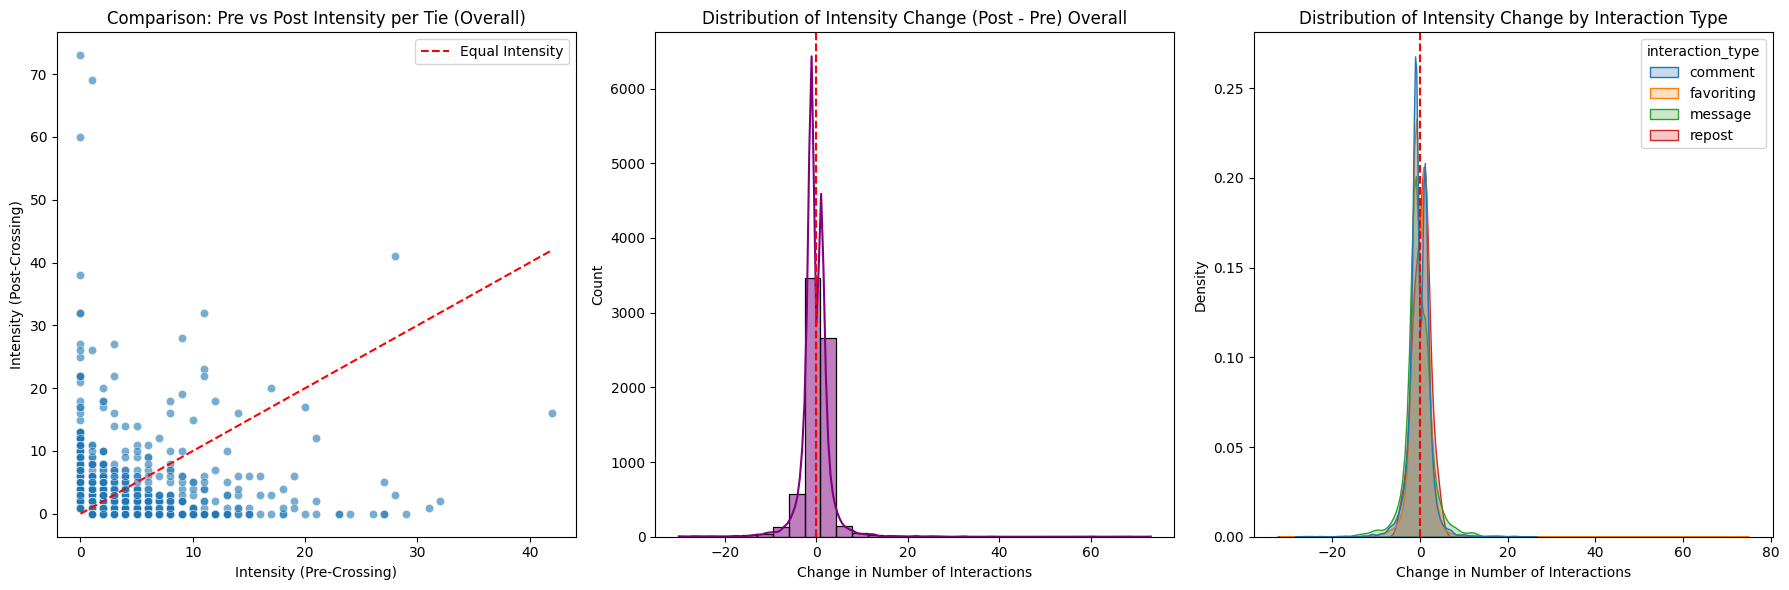

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the intensity data
interactions_df = build_interactions(comments, favoritings, messages, reposts)
recip_df = reciprocal_ties(affiliations, creators)
tcross_df = compute_tcross(affiliations, creators)
intensity_data = intensity_pre_post(interactions_df, recip_df, tcross_df)

# Create the visualization
plt.figure(figsize=(18, 6)) # Increased figure size to accommodate more plots

# Subplot 1: Scatter plot of Pre vs Post intensity (overall)
plt.subplot(1, 3, 1) # Changed to 1 row, 3 columns
sns.scatterplot(data=intensity_data, x='intensity_pre', y='intensity_post', alpha=0.6)
plt.plot([0, intensity_data['intensity_pre'].max()], [0, intensity_data['intensity_pre'].max()], 'r--', label='Equal Intensity')
plt.title('Comparison: Pre vs Post Intensity per Tie (Overall)')
plt.xlabel('Intensity (Pre-Crossing)')
plt.ylabel('Intensity (Post-Crossing)')
plt.legend()

# Subplot 2: Distribution of changes (overall)
plt.subplot(1, 3, 2) # Changed to 1 row, 3 columns
intensity_data['change'] = intensity_data['intensity_post'] - intensity_data['intensity_pre']
sns.histplot(intensity_data['change'], bins=30, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Intensity Change (Post - Pre) Overall')
plt.xlabel('Change in Number of Interactions')

# Subplot 3: Distribution of changes by interaction type
plt.subplot(1, 3, 3) # Added a new subplot
sns.kdeplot(data=intensity_data, x='change', hue='interaction_type', fill=True, common_norm=False)
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Intensity Change by Interaction Type')
plt.xlabel('Change in Number of Interactions')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

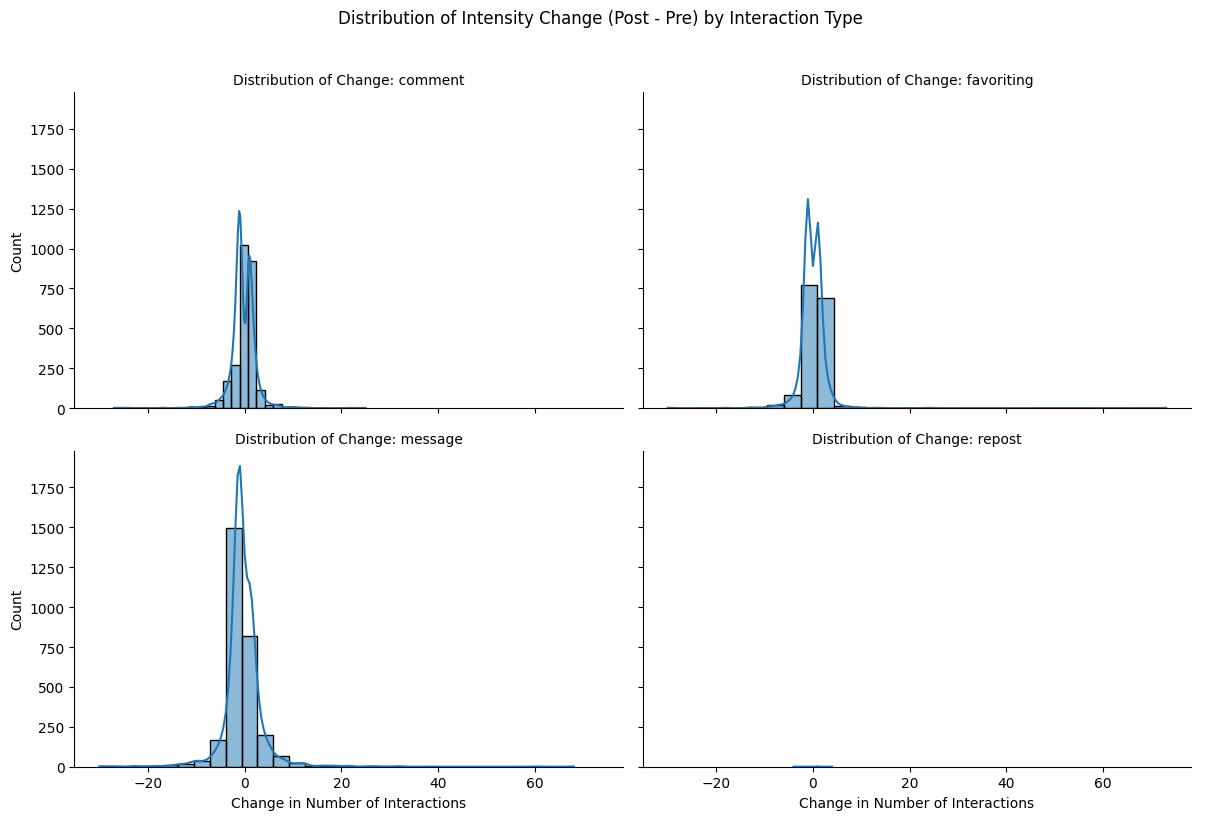

In [18]:
# Recalculate intensity_data and add 'change' column if not already present
# (Ensuring data is fresh in case previous cell wasn't run again)
interactions_df = build_interactions(comments, favoritings, messages, reposts)
recip_df = reciprocal_ties(affiliations, creators)
tcross_df = compute_tcross(affiliations, creators)
intensity_data = intensity_pre_post(interactions_df, recip_df, tcross_df)
intensity_data['change'] = intensity_data['intensity_post'] - intensity_data['intensity_pre']

# Create a FacetGrid to plot the distribution of change for each interaction type separately
g = sns.FacetGrid(intensity_data, col='interaction_type', col_wrap=2, height=4, aspect=1.5)
g.map(sns.histplot, 'change', bins=30, kde=True)
g.set_axis_labels('Change in Number of Interactions', 'Count')
g.set_titles('Distribution of Change: {col_name}')
g.add_legend()
plt.suptitle('Distribution of Intensity Change (Post - Pre) by Interaction Type', y=1.02) # Adjust suptitle position
plt.tight_layout()
plt.show()

This set of plots focuses on each interaction type (comment, favoriting, message, repost), showing how the number of interactions changed from the pre-crossing to the post-crossing period. The red vertical dashed line at 0 helps to quickly identify if the interactions generally increased, decreased, or remained stable for that specific type.

####**Interaction Switching Metric**

In [19]:
def interaction_switching_metrics(interactions, tcross, min_pre_partners=0):

    # Keep only creators who crossed threshold
    crossed = tcross.index
    ev = interactions[interactions["source"].isin(crossed)].copy()

    # Attach creator’s tcross to their interaction rows
    ev = ev.merge(
        tcross.reset_index(),
        left_on="source",
        right_on="contact_id",
        how="inner"
    )

    # Parse interaction and crossing timestamps
    # Remove dayfirst=True as it's causing incorrect parsing for YYYY-MM-DD format.
    ev["time"] = pd.to_datetime(ev["time"])
    ev["tcross"] = pd.to_datetime(ev["tcross"])

    # Label each interaction as pre/post crossing.
    ev["window"] = np.where(ev["time"] < ev["tcross"], "pre", "post")

    results = []

    for u, g in ev.groupby("source"):

        pre_partners = set(g[g["window"] == "pre"]["target"])
        post_partners = set(g[g["window"] == "post"]["target"])

        if len(pre_partners) < min_pre_partners:
            continue

        # Forms all partners
        union = pre_partners.union(post_partners)
        # Forms repeated partners
        intersection = pre_partners.intersection(post_partners)

        # Stability: overlap divided by union
        jaccard = len(intersection) / len(union) if len(union) > 0 else np.nan

        # Switching: new post-only partners divided by post partners
        new_share = len(post_partners - pre_partners) / len(post_partners) if len(post_partners) > 0 else np.nan

        results.append({
            "creator_id": u,
            "n_pre_partners": len(pre_partners),
            "n_post_partners": len(post_partners),
            "jaccard_similarity": jaccard,
            "new_partner_share": new_share
        })

    return pd.DataFrame(results)

switch_metrics = interaction_switching_metrics(build_interactions(comments, favoritings, messages, reposts), compute_tcross(affiliations, creators))
display(switch_metrics)

,creator_id,n_pre_partners,n_post_partners,jaccard_similarity,new_partner_share
0,54846,13,29,0.105263,0.862069
1,54847,0,25,0.000000,1.000000
2,54861,7,17,0.000000,1.000000
3,54866,2,1,0.000000,1.000000
4,54869,71,79,0.079137,0.860759
...,...,...,...,...,...
10918,93702,4,11,0.071429,0.909091
10919,93703,0,4,0.000000,1.000000
10920,93705,2,19,0.000000,1.000000
10921,93712,4,192,0.000000,1.000000


Plot interpretation:
1. **Jaccard Similarity** = ∣ Pre ∩ Post ∣ / ∣ Pre ∪ Post ∣
    - 1 → same partners
    - 0 → completely different partners

After crossing the follower (n = 100) threshold:
  - Creators are interacting with largely different creators.
  - Partner switching is strong.
  - Status transition → reallocation of social attention

2. **New Partner Share** = | Post - Pre | ​/ | Post |
    - 1 → all post partners are new
    - 0 → no new partners

After crossing the follower (n = 100) threshold:
- Creators overwhelmingly interact with new creators.
- Post-threshold interactions are largely not with prior partners.
- This strongly supports a status-driven social expansion or redirection effect.

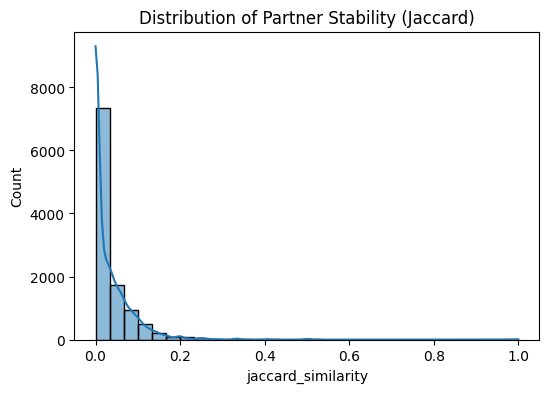

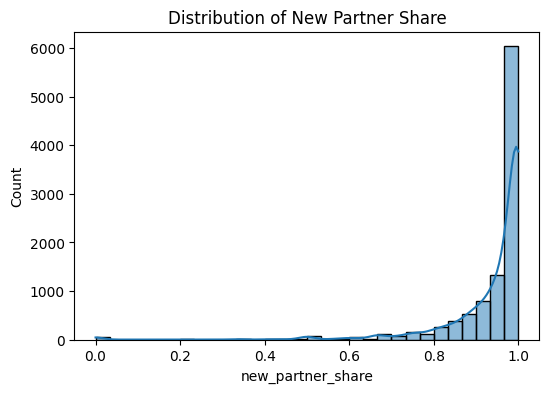

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.histplot(switch_metrics["jaccard_similarity"], bins=30, kde=True)
plt.title("Distribution of Partner Stability (Jaccard)")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(switch_metrics["new_partner_share"], bins=30, kde=True)
plt.title("Distribution of New Partner Share")
plt.show()

In [21]:
switch_metrics["n_pre_partners"].describe()

,n_pre_partners
count,10923.000000
mean,15.382496
std,35.231946
min,0.000000
25%,2.000000
50%,7.000000
75%,17.000000
max,1775.000000


#### **Following Switching Metrics**
Analyze how creators' *following* behavior changes after they cross a follower threshold.

In [22]:
def following_switching_metrics(affiliations, tcross, window_days):
    # Keep only creators who crossed threshold
    crossed = tcross.index
    # Filter affiliations to only include fan_id's that are in the tcross index
    a = affiliations[affiliations["fan_id"].isin(crossed)].copy()

    # Attach creator’s tcross to their following events
    merged_a = a.merge(
        tcross.reset_index(),
        left_on="fan_id",
        right_on="contact_id",
        how="inner"
    )
    # Drop the redundant 'contact_id_y' (the creator ID from tcross.reset_index())
    a = merged_a.drop(columns=["contact_id_y"])
    # Rename 'contact_id_x' (the actual followed user ID) back to 'contact_id'
    a = a.rename(columns={"contact_id_x": "contact_id"})

    # Parse created_at and tcross timestamps
    # Ensure 'created_at' and 'tcross' are datetime objects
    a["created_at"] = pd.to_datetime(a["created_at"], errors="coerce")
    a["tcross"] = pd.to_datetime(a["tcross"], errors="coerce")

    # Drop rows where 'created_at' or 'tcross' became NaT after coercion
    a = a.dropna(subset=["created_at", "tcross"])

    # Calculate post_end timestamp
    a["post_end"] = a["tcross"] + pd.Timedelta(days=window_days)

    # Label each following event as pre/post crossing.
    pre_condition = a["created_at"] < a["tcross"]
    post_condition = (a["created_at"] >= a["tcross"]) & (a["created_at"] <= a["post_end"])

    a["window"] = np.select([pre_condition, post_condition], ["pre", "post"], default=None)

    # Filter out rows that are not 'pre' or 'post' (i.e., outside the defined windows)
    a = a.dropna(subset=["window"])

    results = []

    # 6. Iterate through each unique 'fan_id' (creator)
    for u, g in a.groupby("fan_id"):
        pre_followed = set(g[g["window"] == "pre"]["contact_id"])
        post_followed = set(g[g["window"] == "post"]["contact_id"])

        # 7. Calculate Jaccard similarity
        union_size = len(pre_followed.union(post_followed))
        intersection_size = len(pre_followed.intersection(post_followed))
        jaccard = intersection_size / union_size if union_size > 0 else np.nan

        # 8. Calculate new followed share
        new_followed_count = len(post_followed - pre_followed)
        new_share = new_followed_count / len(post_followed) if len(post_followed) > 0 else np.nan

        results.append({
            "creator_id": u,
            "n_pre_followed": len(pre_followed),
            "n_post_followed": len(post_followed),
            "jaccard_similarity": jaccard,
            "new_followed_share": new_share
        })

    return pd.DataFrame(results)

In [23]:
following_switching_df = following_switching_metrics(
    affiliations=affiliations,
    tcross=tcross_df,
    window_days=WINDOW_DAYS
)

display(following_switching_df)

,creator_id,n_pre_followed,n_post_followed,jaccard_similarity,new_followed_share
0,54846,54,0,0.0,NaN
1,54861,7,2,0.0,1.0
2,54866,33,1,0.0,1.0
3,54869,171,23,0.0,1.0
4,54874,97,35,0.0,1.0
...,...,...,...,...,...
10387,93702,1,15,0.0,1.0
10388,93703,0,7,0.0,1.0
10389,93705,62,6,0.0,1.0
10390,93712,418,840,0.0,1.0


**Interpretation of Following Switching Metrics**
- After crossing the follower threshold, creators exhibit a strong tendency to significantly change their following patterns. They tend to follow a largely new and different set of users, as evidenced by low Jaccard similarity and high new followed share.
- This suggests that achieving a certain level of influence (crossing the threshold) might lead creators to re-evaluate their social connections or perhaps indicates a shift in their role or interests within the platform, prompting them to connect with a new community or type of content.